# Infraestrutura
Para as questões a seguir, você deverá executar códigos em um notebook Jupyter, rodando em ambiente local, certifique-se que:

## 1. Você está rodando em Python 3.9+
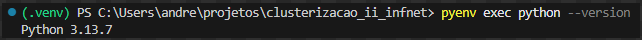

## 2. Você está usando um ambiente virtual: Virtualenv ou Anaconda


## 3. Todas as bibliotecas usadas nesse exercícios estão instaladas em um ambiente virtual específico
Prévia (há muitas bibliotecas)  
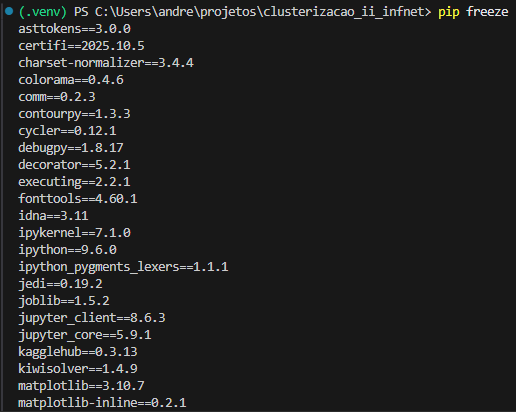

## 4. Gere um arquivo de requerimentos (requirements.txt) com os pacotes necessários. É necessário se certificar que a versão do pacote está disponibilizada.


## 5. Tire um printscreen do ambiente que será usado rodando em sua máquina.
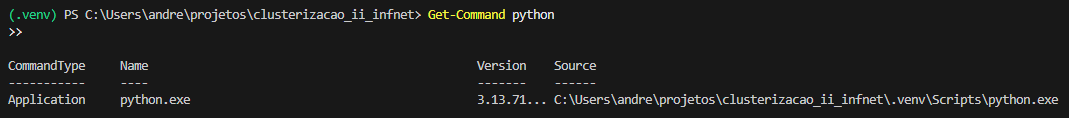

## 6. Disponibilize os códigos gerados, assim como os artefatos acessórios (requirements.txt) e instruções em um repositório GIT público. (se isso não for feito, o diretório com esses arquivos deverá ser enviado compactado no moodle).
https://github.com/andreiluizpereira/clusterizacao_ii_infnet.git

# Escolha de base de dados
Para as questões a seguir, usaremos uma base de dados e faremos a análise exploratória dos dados, antes da clusterização.

## 1. Escolha uma base de dados para realizar o trabalho. Essa base será usada em um problema de clusterização.
https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data

## 2. Escreva a justificativa para a escolha de dados, dando sua motivação e objetivos.
É a mesma base do projeto da disciplina anterior "Algoritmos para clusterização de dados". Optei por usar os mesmos dados para demonstrar a continuação do projeto (validação) das clusterizações feitas no projeto anterior, mas com melhorias.

## 3. Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

Observando os boxplots gerados, nota-se que as variáveis apresentam escalas bastante distintas. Variáveis como `gdpp` e `income` possuem valores consideravelmente maiores em comparação às demais.

Esta diferença de escala representa um problema, pois algoritmos baseados em distância euclidiana, como o K-Means, atribuem maior peso às variáveis com valores absolutos maiores. Portanto, torna-se necessária a padronização dos dados antes de realizar a clusterização.

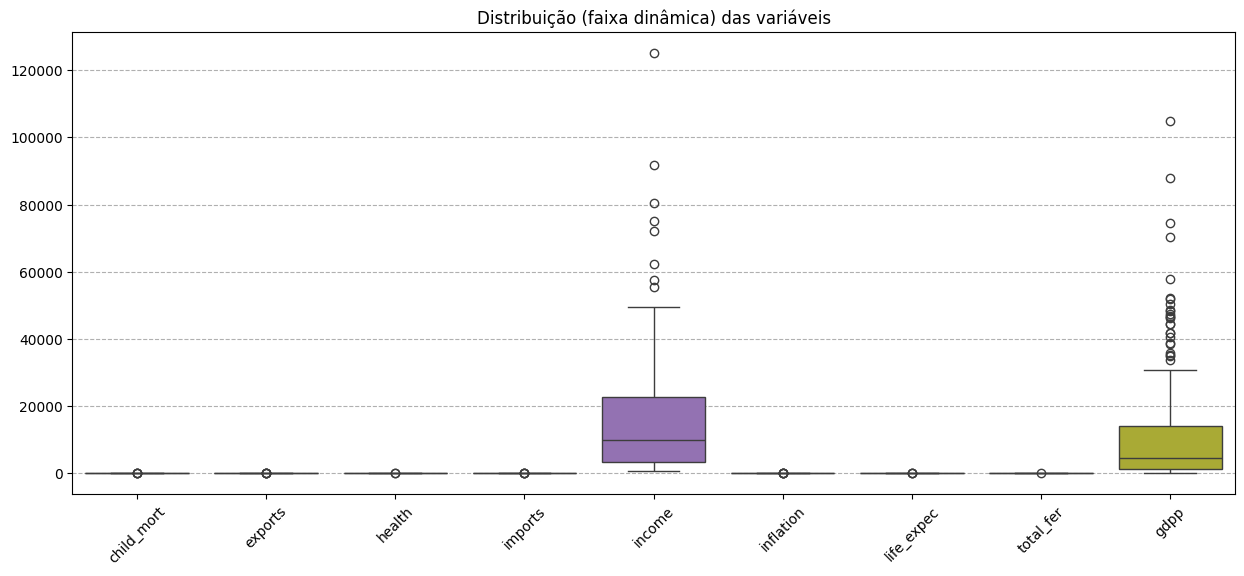

In [1]:
# Importações, funções e carregamento do dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Carregamento dos dados
df = pd.read_csv('data/Country-data.csv')
X = df.drop('country', axis=1)  # Variáveis para clusterização

# Visualização da distribuição das variáveis
plt.figure(figsize=(15, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.title('Distribuição (faixa dinâmica) das variáveis')
plt.show()

## 4. Realize o pré-processamento adequado dos dados. Descreva os passos necessários.

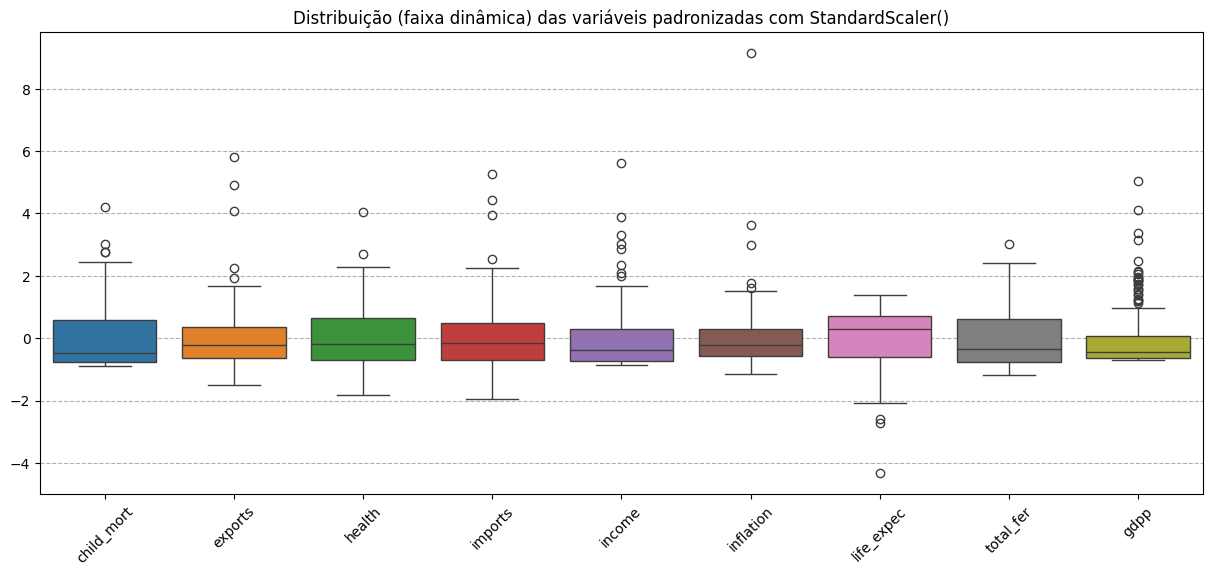

In [2]:
# Padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualização após padronização
plt.figure(figsize=(15, 6))
sns.boxplot(data=pd.DataFrame(X_scaled, columns=X.columns))
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.title('Distribuição (faixa dinâmica) das variáveis padronizadas com StandardScaler()')
plt.show()

# Clusterização
Para os dados pré-processados da etapa anterior você irá:

## 1. Realizar o agrupamento dos dados, escolhendo o número ótimo de clusters. Para tal, use o índice de silhueta e as técnicas:

### a. K-Médias

In [ ]:
# Definir um range de valores de K a serem testados
k_range = range(2, 11)
kmeans_values = []

# Para cada K, aplicar o algoritmo K-Means aos dados padronizados
for k_value in k_range:
    kmeans = KMeans(n_clusters=k_value, random_state=42, n_init=10).fit(X_scaled)
    
    kmeans_silhouette_score = silhouette_score(X=X_scaled, labels=kmeans.labels_)
    kmeans_values.append({
        'k': k_value,
        'score': kmeans_silhouette_score
    })

# Identificar o maior valor
kmeans_max_silhouette_score = max(v['score'] for v in kmeans_values)
best_k = [v['score'] for v in kmeans_values].index(kmeans_max_silhouette_score) + 2

print(f"KMEANS -> K: {best_k}\tSilhouette Score: {kmeans_max_silhouette_score:.4f}")

KMEANS -> K: 5	Silhouette Score: 0.2993


### b. DBScan

In [35]:
# GRID-BASED: Criar um dicionário de combinações de hiperparâmetros para DBSCAN
eps_values = np.linspace(start=0.05, stop=5, num=20)
min_samples_values = range(3, 2 * X_scaled.shape[1] + 1)

param_grid = []
for eps in eps_values:
  for min_samples in min_samples_values:
    param_grid.append({
        'eps': eps,
        'min_samples': min_samples
    })
    
print('N param', len(param_grid), "\n")

# Buscar a melhor combinação de hiperparâmetros com base no Silhouette Score
db_values = []
best_params = None
best_score = -1

for param in param_grid:

  eps = param['eps']
  min_samples = param['min_samples']

  dbscan_model = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
  labels = dbscan_model.labels_

  # evitar casos com apenas um cluster
  if len(set(labels)) > 1:

    score = silhouette_score(X_scaled, labels)

    if score > best_score:
      best_score = score
      best_params = param
      
  db_values.append({
      'eps': eps,
      'min_samples': min_samples,
      'score': score
  })
    
print(f"DBSCAN -> min_samples: {best_params['min_samples' ]}\t eps: {best_params['eps']:.4f}\t Silhouette Score: {best_score:.4f}")

N param 320 

DBSCAN -> min_samples: 3	 eps: 4.2184	 Silhouette Score: 0.6303


### 2. Com os resultados em mão, descreva o processo de mensuração do índice de silhueta. Mostre o gráfico e justifique o número de clusters escolhidos.

Conforme os gráficos abaixo, no `K-Means` o melhor `k` que maximiza o `Silhouette Score` é `k=5`. No `DBSCAN`, os hiperparâmetros `min_samples` e `eps` são ajustados juntos, portanto os melhores hiperparâmetros que maximizam o `Silhouette Score` são `eps=4.22` e `min_samples=3`

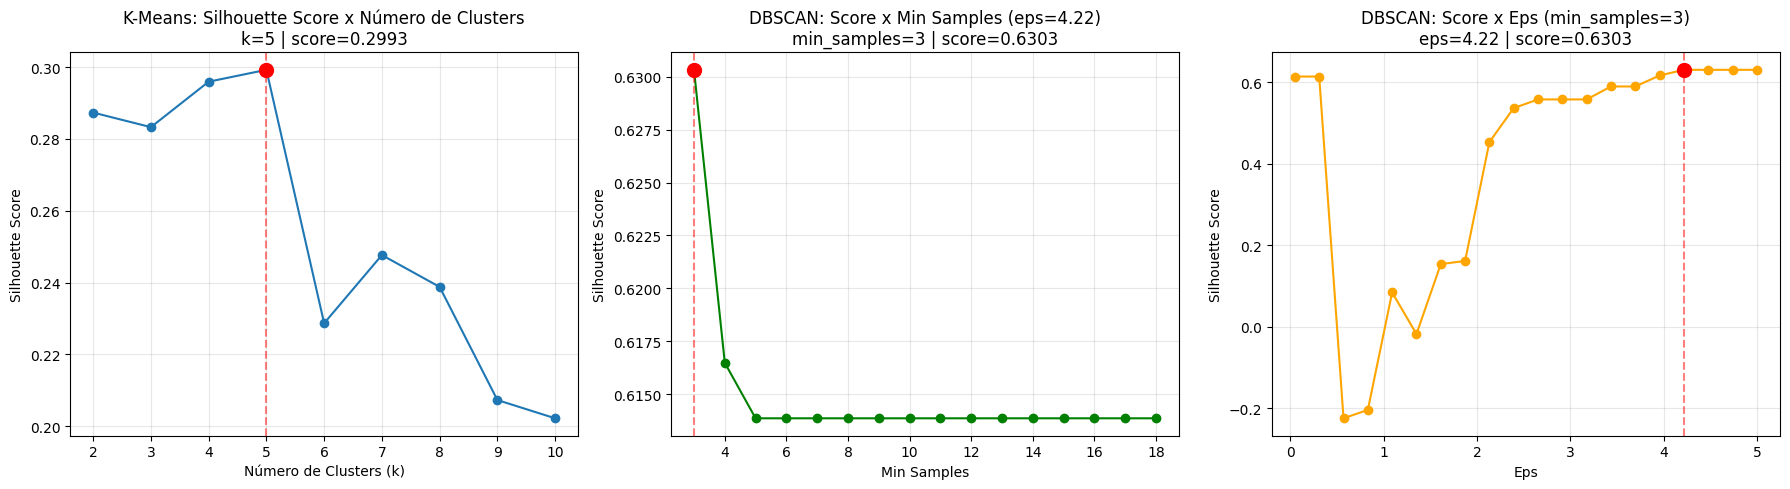

In [46]:
# Preparar dados para os gráficos DBSCAN
# Filtrar valores com o melhor eps (variando min_samples)
db_best_eps = [v for v in db_values if v['eps'] == best_params['eps']]
db_best_eps_sorted = sorted(db_best_eps, key=lambda x: x['min_samples'])

# Filtrar valores com o melhor min_samples (variando eps)
db_best_min_samples = [v for v in db_values if v['min_samples'] == best_params['min_samples']]
db_best_min_samples_sorted = sorted(db_best_min_samples, key=lambda x: x['eps'])

# Criar figura com 3 subplots
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Gráfico 1: K-Means
ax1.plot([v['k'] for v in kmeans_values], [v['score'] for v in kmeans_values], marker='o')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title(f'K-Means: Silhouette Score x Número de Clusters\nk={best_k} | score={kmeans_max_silhouette_score:.4f}', fontsize=12)
ax1.plot(best_k, kmeans_max_silhouette_score, 'ro', markersize=10)
ax1.axvline(x=best_k, color='red', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3)

# Gráfico 2: DBSCAN - Silhouette x Min Samples (eps fixo)
ax2.plot([v['min_samples'] for v in db_best_eps_sorted], 
         [v['score'] for v in db_best_eps_sorted], marker='o', color='green')
ax2.set_xlabel('Min Samples')
ax2.set_ylabel('Silhouette Score')
ax2.set_title(f'DBSCAN: Score x Min Samples (eps={best_params["eps"]:.2f})\nmin_samples={best_params["min_samples"]} | score={best_score:.4f}', fontsize=12)
ax2.plot(best_params["min_samples"], best_score, 'ro', markersize=10)
ax2.axvline(x=best_params["min_samples"], color='red', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)

# Gráfico 3: DBSCAN - Silhouette x Eps (min_samples fixo)
ax3.plot([v['eps'] for v in db_best_min_samples_sorted], 
         [v['score'] for v in db_best_min_samples_sorted], marker='o', color='orange')
ax3.set_xlabel('Eps')
ax3.set_ylabel('Silhouette Score')
ax3.set_title(f'DBSCAN: Score x Eps (min_samples={best_params["min_samples"]})\neps={best_params["eps"]:.2f} | score={best_score:.4f}', fontsize=12)
ax3.plot(best_params["eps"], best_score, 'ro', markersize=10)
ax3.axvline(x=best_params["eps"], color='red', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3. Compare os dois resultados, aponte as semelhanças e diferenças e interprete.
O resultado do Silhouette no K-Means foi superior, isso indica que os clusters tem formato predominantemente esférico.  
Também é possível observar o comportamento do gráfico do Silhouette Score em função de X que é semelhante em ambos os algoritmos. O score sobe na faixa de 3 a 4, depois tem uma queda brusca na faixa de 5 a 6, sobe novamente na faixa de 6 a 7 e volta a cair.

### 4. Escolha mais duas medidas de validação para comparar com o índice de silhueta e analise os resultados encontrados. Observe, para a escolha, medidas adequadas aos algoritmos.

### 5. Realizando a análise, responda: A silhueta é um o índice indicado para escolher o número de clusters para o algoritmo de DBScan?

#### Parte 2.3 - Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

Observando os boxplots gerados, nota-se que as variáveis apresentam escalas bastante distintas. Variáveis como `gdpp` e `income` possuem valores consideravelmente maiores em comparação às demais.

Esta diferença de escala representa um problema, pois algoritmos baseados em distância euclidiana, como o K-Means, atribuem maior peso às variáveis com valores absolutos maiores. Portanto, torna-se necessária a padronização dos dados antes de realizar a clusterização.

In [ ]:
# Visualização da distribuição das variáveis
plt.figure(figsize=(15, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.title('Distribuição (faixa dinâmica) das variáveis')
plt.show()

#### Parte 2.4 - Realize o pré-processamento adequado dos dados.

In [ ]:
# Padronização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualização após padronização
plt.figure(figsize=(15, 6))
sns.boxplot(data=pd.DataFrame(X_scaled, columns=X.columns))
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.title('Distribuição (faixa dinâmica) das variáveis padronizadas com StandardScaler()')
plt.show()

#### Parte 3.1 - Para os dados pré-processados da etapa anterior, você irá:

**Realizar o agrupamento dos países em 3 grupos distintos.**  

- **a.** K-Médias  

In [ ]:
# Aplicação do K-Means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
df['kmeans_cluster'] = kmeans.labels_

- **b.** Clusterização Hierárquica 

In [ ]:
# Aplicação do HClust com 3 clusters
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df['hierarchical_cluster'] = hierarchical_cluster.fit_predict(X_scaled)

#### Parte 3.2 - Para os resultados do K-Médias:
a. Interprete cada um dos clusters obtidos citando:  

In [ ]:
# Contagem de países por cluster
counts_k = df['kmeans_cluster'].value_counts()
print(f"Contagem de países por cluster (K-Means):")
print(f"Cluster 0: {counts_k.get(0, 0)} países")
print(f"Cluster 1: {counts_k.get(1, 0)} países")
print(f"Cluster 2: {counts_k.get(2, 0)} países")

##### i. Qual a distribuição das dimensões em cada grupo

A partir da análise do gráfico de barras com as médias normalizadas, observa-se o seguinte perfil para cada cluster:

**Cluster 0**: Países com indicadores intermediários, situando-se entre os extremos de desenvolvimento econômico e social.

**Cluster 1**: Países desenvolvidos, caracterizados por elevados valores de `gdpp` e `income`, alta expectativa de vida (`life_expec`) e baixa mortalidade infantil (`child_mort`).

**Cluster 2**: Países em desenvolvimento, apresentando baixo PIB e renda per capita, alta mortalidade infantil e menor expectativa de vida.

In [ ]:
# Análise das médias por cluster
cluster_means_scaled = pd.DataFrame(X_scaled, columns=X.columns)
cluster_means_scaled['cluster'] = kmeans.labels_
cluster_means_scaled = cluster_means_scaled.groupby('cluster').mean().round(2)

# Visualização das médias normalizadas por cluster
cluster_means_scaled.T.plot(kind='bar', figsize=(12, 6))
plt.title('Distribuição normalizada das dimensões por cluster (K-Means)')
plt.ylabel('Valor médio (normalizado) por variável')
plt.xlabel('Dimensões (variáveis)')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### ii. O país que, de acordo com o algoritmo, melhor representa o seu agrupamento. Justifique.

In [ ]:
# Encontrar o país mais próximo do centróide de cada cluster
# (análogo ao medóide, mas calculado a partir dos resultados do K-Means)

for cluster_id in range(kmeans.n_clusters):
    # Índices dos pontos no cluster
    cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
    
    # Centróide do cluster
    centroid = kmeans.cluster_centers_[cluster_id]
    
    # Dados do cluster
    cluster_data = X_scaled[cluster_indices]
    
    # Calcula a distância euclidiana de cada ponto ao centróide
    distances = np.linalg.norm(cluster_data - centroid, axis=1)
    
    # Encontra o índice do ponto mais próximo
    closest_point_index_in_cluster = np.argmin(distances)
    
    # Mapeia de volta para o índice original no dataframe
    original_index = cluster_indices[closest_point_index_in_cluster]
    
    # Exibe o país representativo
    representative_country = df.iloc[original_index]
    print(f"\nCluster {cluster_id}:")
    print(f"  País representativo: {representative_country['country']}")
    print(f"  Distância ao centróide: {distances[closest_point_index_in_cluster]:.4f}")

O país representativo de cada cluster corresponde àquele mais próximo do centróide, funcionando como o elemento mais típico do grupo.

**Cluster 0 - Suriname**: Apresenta valores intermediários nas variáveis analisadas, posicionando-se entre os dois extremos socioeconômicos identificados.

**Cluster 1 - Iceland**: País desenvolvido que exemplifica o perfil do cluster com alta renda per capita e elevada expectativa de vida.

**Cluster 2 - Guinea**: Representa o perfil de país em desenvolvimento, com baixa renda e alta taxa de mortalidade infantil.

#### Parte 3.3 - Para os resultados da Clusterização Hierárquica, apresente o dendrograma e interprete os resultados.

In [ ]:
# Criação do dendrograma
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(14, 10))
dendrogram(
    linked,
    orientation='top',
    labels=df['country'].values,
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Dendrograma - Clusterização Hierárquica (Ward)')
plt.xlabel('Países')
plt.ylabel('Distância')
plt.show()

O dendrograma apresenta a estrutura hierárquica de agrupamento dos países. A altura das ligações indica a distância entre os clusters, quanto maior a altura, maior a dissimilaridade entre os grupos sendo unidos.

É possível identificar a formação de três grandes grupos, resultado consistente com o obtido pelo K-Means. Países com perfis semelhantes (como Noruega e Suíça) são agrupados nos níveis iniciais da hierarquia, enquanto países com características muito distintas apenas se unem nos níveis superiores.

O método Ward busca minimizar a variância entre os clusters, resultando em grupos com tamanhos relativamente equilibrados.

#### Parte 3.4 - Compare os dois resultados, aponte as semelhanças e diferenças e interprete.

**Semelhanças:**
- Ambos os algoritmos identificaram três grupos principais com perfis socioeconômicos distintos: países desenvolvidos, em desenvolvimento e subdesenvolvidos.
- A composição central dos clusters é bastante similar, com países como Suíça, Noruega e Luxemburgo consistentemente agrupados juntos em ambos os métodos.

**Diferenças:**
- O K-Means requer a definição prévia do número de clusters, enquanto a clusterização hierárquica permite esta escolha a posteriori através da análise do dendrograma.
- O K-Means apresenta variabilidade nos resultados devido à inicialização aleatória dos centroides, ao passo que o método hierárquico produz resultados determinísticos.
- O dendrograma gerado pelo método hierárquico oferece informações adicionais sobre a estrutura e relações entre os grupos.

**Interpretação:**
Ambos os métodos demonstraram eficácia na segmentação dos países. O K-Means destaca-se pela eficiência computacional e simplicidade de implementação. Já a clusterização hierárquica fornece uma visão mais detalhada da estrutura dos grupos.

#### Parte 4 - Escolha de algoritmos

#### 4.1 - Escreva em tópicos as etapas do algoritmo de K-médias até sua convergência.

1.  **Inicialização:** Definir o número K de clusters e inicializar K centróides de forma aleatória no espaço de dados.
2.  **Atribuição:** Calcular a distância de cada ponto para todos os centróides e atribuí-lo ao cluster correspondente ao centróide mais próximo.
3.  **Atualização:** Recalcular a posição de cada centróide como a média aritmética de todos os pontos pertencentes ao respectivo cluster.
4.  **Convergência:** Repetir os passos de atribuição e atualização até que os centróides se estabilizem ou até atingir o número máximo de iterações estabelecido.

#### 4.2 - Refaça o algoritmo apresentado na questão 1 a fim de garantir que o cluster seja representado pelo dado mais próximo ao seu baricentro em todas as iterações do algoritmo (K-Medóides).

In [ ]:
# Inicialização do K-Means com medóides (pontos reais) ao invés de centroides aleatórios
# Após inicialização, o algoritmo segue normalmente calculando centroides como médias

np.random.seed(42)
# Seleciona 3 pontos aleatórios do dataset como centros iniciais
medoid_indices = np.random.choice(len(X_scaled), size=3, replace=False)
initial_centers = X_scaled[medoid_indices]

# Aplica K-Means com os medóides como inicialização
kmeans_medoid_init = KMeans(n_clusters=3, init=initial_centers, n_init=1, random_state=42)
kmeans_medoid_init.fit(X_scaled)

print("Países selecionados como pontos iniciais (medóides):")
for i, idx in enumerate(medoid_indices):
    print(f"Cluster {i}: {df.iloc[idx]['country']}")

print(f"\nAlgoritmo convergiu em {kmeans_medoid_init.n_iter_} iterações")

#### 4.3 - O algoritmo de K-médias é sensível a outliers nos dados. Explique.

A sensibilidade do K-Means a outliers decorre do cálculo do centróide pela média aritmética dos pontos. Quando há presença de outliers (pontos com valores distantes do conjunto principal), estes exercem influência desproporcional sobre a média, deslocando o centróide para longe da região de maior concentração de pontos do cluster.

Esta distorção compromete a representatividade do centróide e pode resultar em classificações incorretas.

#### 4.4 - Por que o algoritmo de DBScan é mais robusto à presença de outliers?

O DBSCAN fundamenta-se no conceito de densidade de pontos, classificando-os em três categorias:

1.  **Pontos Centrais:** Possuem quantidade mínima de vizinhos (`min_samples`) dentro de um raio definido (`eps`).
2.  **Pontos de Borda:** Encontram-se na vizinhança de pontos centrais, mas não atendem ao critério de ponto central.
3.  **Ruído:** Pontos isolados que não se enquadram nas categorias anteriores.

Como outliers caracterizam-se por estarem em regiões de baixa densidade, o DBSCAN os identifica naturalmente como ruído, impedindo que influenciem a formação dos clusters, que são construídos exclusivamente a partir de regiões densas.